gen	nevals	avg   	std    	min   	max  
0  	375   	-13494	2374.67	-22082	-6491
1  	391   	-11516.4	2220.17	-17574	-3382
2  	366   	-9679.4 	2267.02	-16948	-1373
3  	402   	-8031.4 	2220.62	-14610	-396 
4  	360   	-6425.77	2082.2 	-11931	-396 
5  	362   	-4848.61	1838.77	-11907	159  
6  	376   	-3501.08	1751.55	-9015 	159  
7  	379   	-2188.01	1630.73	-9454 	164  
8  	381   	-1229.15	1318.94	-6794 	166  
9  	361   	-540.068	1017.06	-5735 	170  
10 	389   	-247.15 	767.574	-5102 	187  
11 	378   	-129.746	723.328	-4545 	188  
12 	389   	-201.76 	856.84 	-6242 	194  
13 	406   	-166.234	798.866	-6267 	194  
14 	363   	-87.504 	680.659	-4136 	200  
15 	398   	-151.214	853.593	-5466 	206  
16 	374   	-51.462 	588.692	-3949 	213  
17 	386   	-118.71 	832.002	-5618 	227  
18 	378   	-68.592 	670.45 	-4866 	229  
19 	387   	-50.232 	700.116	-5015 	229  
20 	366   	-33.504 	653.636	-5348 	231  
21 	357   	-79.076 	761.214	-5874 	234  
22 	370   	-66.566 	733.617	-4698 	235  
23 	389   	-82.2   	

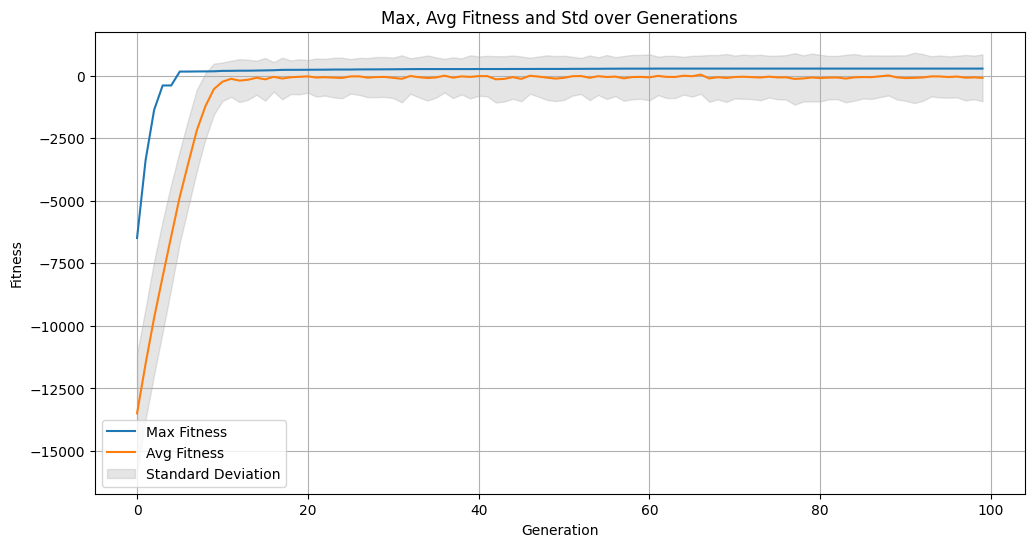

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools

# problem parameters
NBR_ITEMS = 100
MAX_WEIGHT = 1000
RANDOM_SEED = 42
POPULATION_SIZE = 500
NGEN = 100  # number of generations
MUTATION_PROBABILITY = 0.2  # mutation probability
CROSSOVER_PROBABILITY = 0.7   # crossover probability

random.seed(RANDOM_SEED)

# create the items: each item is a (value, weight) tuple
items = np.array([(random.randint(1, 10), random.randint(1, 100)) for _ in range(NBR_ITEMS)])

# fitness and Individual setup in DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximization problem
creator.create("Individual", list, fitness=creator.FitnessMax)

# create the individual: a binary list representing whether to include the item
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NBR_ITEMS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function using vectorized operations
def fitness(individual):
    total_value = np.dot(individual, items[:, 0])
    total_weight = np.dot(individual, items[:, 1])

    # Apply penalty for exceeding weight limit
    penalty = max(0, total_weight - MAX_WEIGHT) * 10
    return total_value - penalty,

# register genetic algorithm components
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # 5% chance to flip any bit
toolbox.register("select", tools.selTournament, tournsize=3)

# manually implementing the GA loop with elitism
def execute_GA():
    pop = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(1)  # keep the best individual
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # evaluate the fitness of the individuals in the population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # keep track of statistics
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields

    # begin the generational loop
    for gen in range(NGEN):
        # select the next generation individuals
        offspring = toolbox.select(pop, len(pop) - 1)  # elitism: keep 1 best individual
        offspring = list(map(toolbox.clone, offspring))

        # apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER_PROBABILITY:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTATION_PROBABILITY:
                toolbox.mutate(mutant)
                del mutant.fitness.values

      # Evaluate fitness only for individuals with invalid fitness values
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_ind:
            ind.fitness.values = toolbox.evaluate(ind)


        # retain the best individual (elitism)
        offspring.append(tools.selBest(pop, 1)[0])

        # replace the population with the offspring
        pop[:] = offspring

        # record the statistics
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)

        # update Hall of Fame
        hof.update(pop)

    return pop, logbook, hof

# execute the GA
pop, log, hof = execute_GA()

# extract statistics for plotting
gen = log.select("gen")
max_fitness_values = log.select("max")
avg_fitness_values = log.select("avg")
std_fitness_values = log.select("std")

# print the best solution
best_individual = hof[0]
best_value = fitness(best_individual)[0]
total_weight = np.dot(best_individual, items[:, 1])
print(f"Best individual: {best_individual}")
print(f"Best fitness (value): {best_value}")
print(f"Total weight: {total_weight}")

# plot the performance graph
plt.figure(figsize=(12, 6))
plt.plot(gen, max_fitness_values, label="Max Fitness")
plt.plot(gen, avg_fitness_values, label="Avg Fitness")
plt.fill_between(gen, [avg - std for avg, std in zip(avg_fitness_values, std_fitness_values)], [avg + std for avg, std in zip(avg_fitness_values, std_fitness_values)], color='gray', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.title("Max, Avg Fitness and Std over Generations")
plt.grid()
plt.show()